## Python notebook to train ML model and save models as pickle file. 

Data Loader...
Load Complete


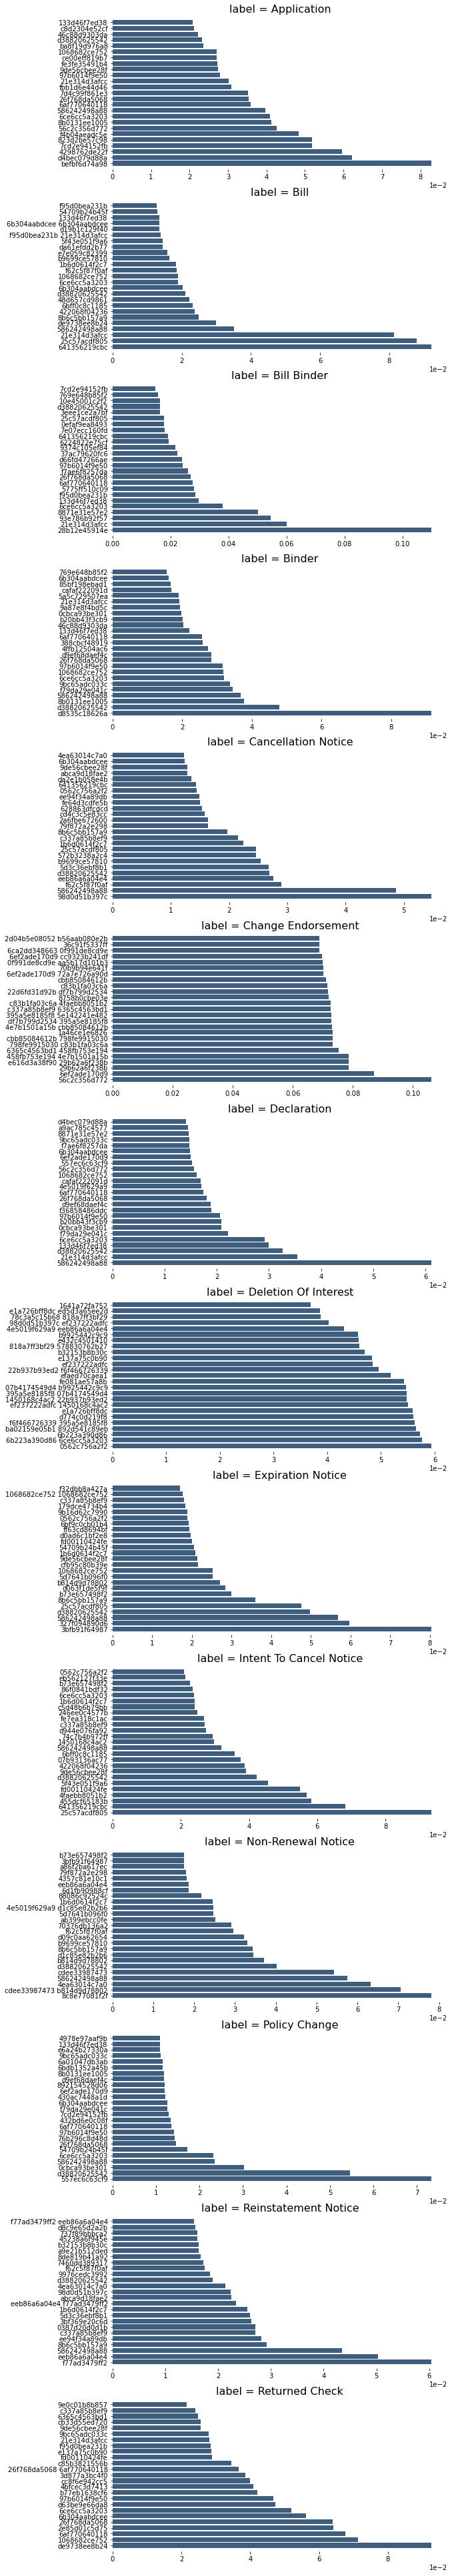

Created Train(90%) and Test(10%) Stratified splits
Training a Classifier
Trained model in 14.8359 seconds
Finished Training
Made predictions in 0.2250 seconds.
F1 score and accuracy score for training set: 0.8886 , 0.8886.
Made predictions in 0.0256 seconds.
F1 score and accuracy score for test set: 0.8666 , 0.8666.


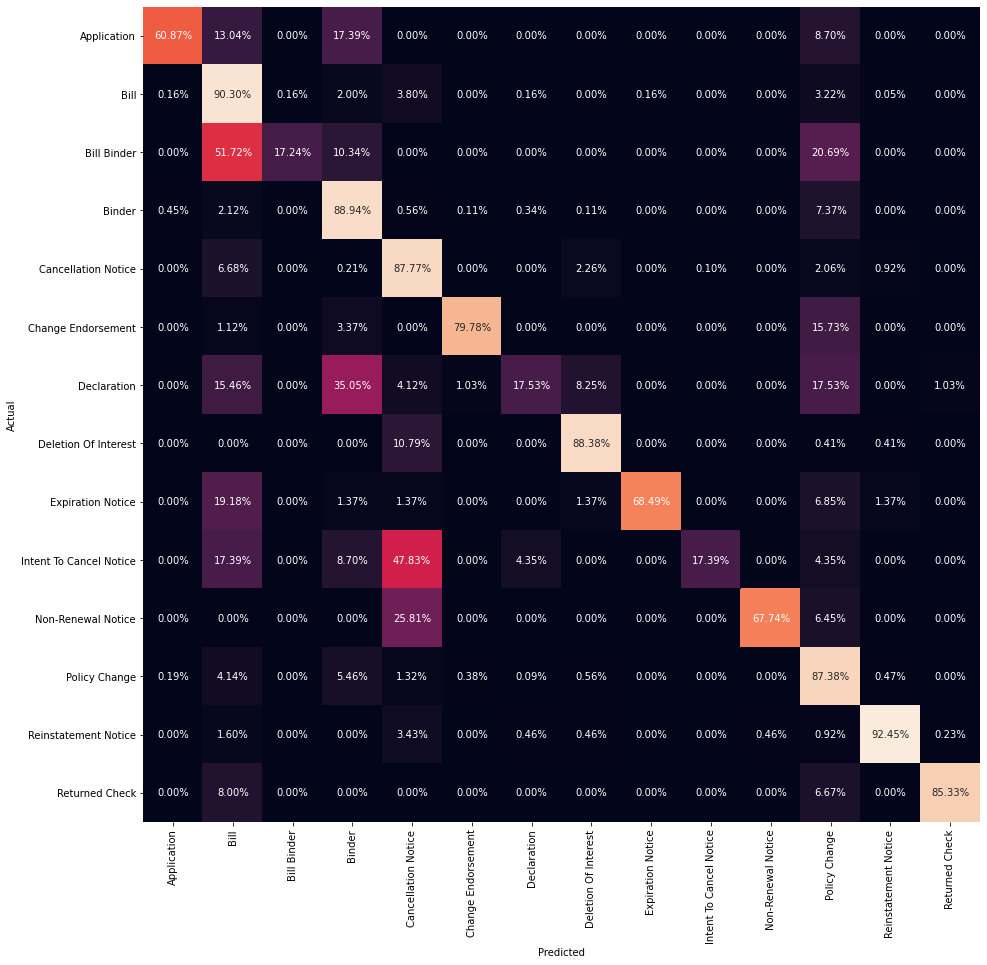

Accuracy: 0.87
Auc: 0.98
Detail:
                         precision    recall  f1-score   support

            Application       0.61      0.61      0.61        23
                   Bill       0.90      0.90      0.90      1896
            Bill Binder       0.62      0.17      0.27        29
                 Binder       0.85      0.89      0.87       895
    Cancellation Notice       0.82      0.88      0.85       973
     Change Endorsement       0.92      0.80      0.86        89
            Declaration       0.63      0.18      0.27        97
   Deletion Of Interest       0.91      0.88      0.90       482
      Expiration Notice       0.94      0.68      0.79        73
Intent To Cancel Notice       0.80      0.17      0.29        23
     Non-Renewal Notice       0.95      0.68      0.79        62
          Policy Change       0.82      0.87      0.84      1062
   Reinstatement Notice       0.96      0.92      0.94       437
         Returned Check       0.97      0.85      0.91  

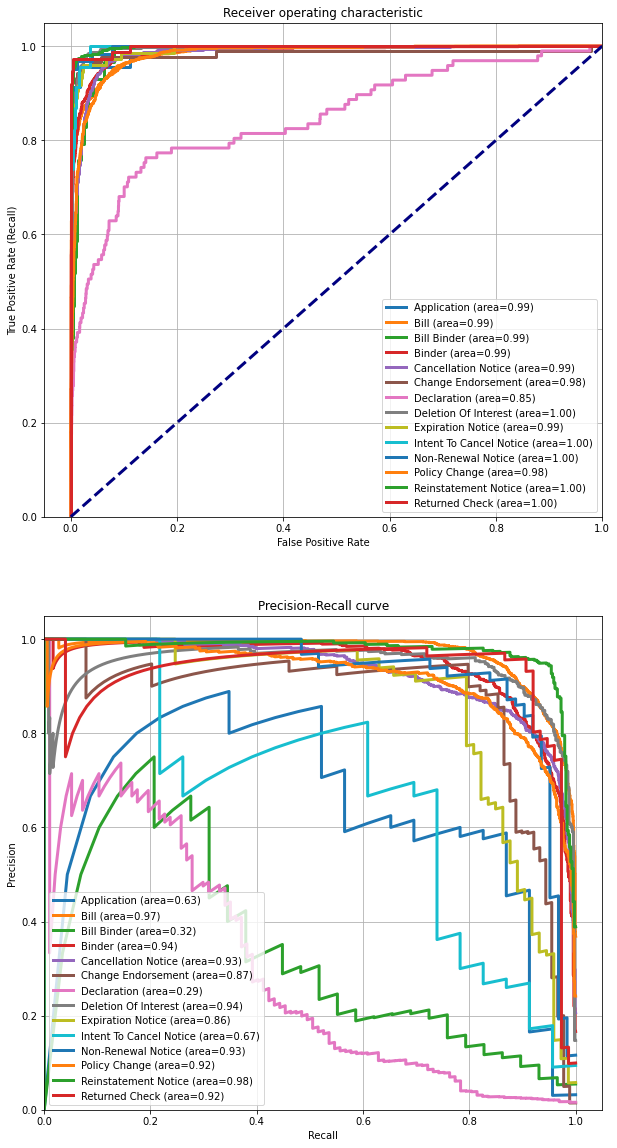

Model saved as pickle file


In [12]:
'''
 File name: train_predict.pynb
 Author: Shoumik Roychoudhury
 Date created: 7/16/2020

'''
import data_util as du
from time import time
import pandas as pd
import pickle as pk
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

class Solution(object):
 
    
    def __init__(self):
        
        print("Data Loader...")
        # Load dataframe and process it
        self.dataframe=du.preprocess("shuffled-full-set-hashed-new.csv")
        print("Load Complete")
        self.dataf = self.dataframe

        # Create train and test sets
        self.X_train,self.X_test,self.y_train,self.y_test = du.create_train_test(self.dataframe)
        print("Created Train(90%) and Test(10%) Stratified splits")
        

    
    
    def train_classifier(self,clf):
        ''' Fits a classifier to the training data. '''

        # Start the clock, train the classifier, stop the clock
        start = time()
        clf.fit(self.X_train, self.y_train)
        end = time()
        
        # Print the training time
        print("Trained model in {:.4f} seconds".format(end - start))
        
        return clf

    def predict_labels(self,clf,features, target):
        ''' Makes predictions using a fit classifier based on F1 score. '''

        # Start the clock, make predictions, stop the clock
        start = time()
        y_pred = clf.predict(features)
        y_prob = clf.predict_proba(features)
        end = time()
        
        # Print testing time
        print("Made predictions in {:.4f} seconds.".format(end - start))
        
       
        

        return f1_score(target, y_pred, labels=range(14), average='micro'), accuracy_score(target, y_pred), y_pred, y_prob

    
    def train_predict(self,clf):
        ''' Train and predict using a classifer based on F1 score. '''

        # Indicate the classifier and the training set size
        print("Training a Classifier")

        # Train the classifier
        trained_clf=self.train_classifier(clf)

        print("Finished Training")

        # Print the results of prediction for both training and testing
        f1, acc, y_pred_train, y_pred_train_proba = self.predict_labels(trained_clf,self.X_train,self.y_train)
        #print(f1, acc)
        print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1, acc))

        f1, acc, y_pred, y_pred_proba= self.predict_labels(trained_clf,self.X_test,self.y_test)
        print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1, acc))
        
        self.show_confusion_matrix(self.y_test, y_pred)
        self.precision_recall_metrics(self.y_test, y_pred, y_pred_proba)
        
        
        
        
        return trained_clf
    
    def precision_recall_metrics(self, y_test, y_pred, predicted_prob):
        ''' Accuracy, Precision, Recall'''
        
        target_names = [x.title() for x in
                        
                        ['APPLICATION',
                        'BILL',
                        'BILL BINDER',
                        'BINDER',
                        'CANCELLATION NOTICE',
                        'CHANGE ENDORSEMENT',
                        'DECLARATION',
                        'DELETION OF INTEREST',
                        'EXPIRATION NOTICE',
                        'INTENT TO CANCEL NOTICE',
                        'NON-RENEWAL NOTICE',
                        'POLICY CHANGE',
                        'REINSTATEMENT NOTICE',
                        'RETURNED CHECK']
                       ]
        
        
        classes = len(target_names)
        y_test_array = pd.get_dummies(y_test, drop_first=False).values
        accuracy = metrics.accuracy_score(y_test, y_pred)
        auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
        print("Accuracy:",  round(accuracy,2))
        print("Auc:", round(auc,2))
        print("Detail:")
        print(classification_report(y_test, y_pred, target_names = target_names))
        
        
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize= (10,20))
        ## Plot roc
        for i in range(classes):
            fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
            ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(target_names[i], 
                              metrics.auc(fpr, tpr))
               )
        ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
        ax[0].legend(loc="lower right")
        ax[0].grid(True)
    
        ## Plot precision-recall curve
        for i in range(classes):
            precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
            ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(target_names[i], 
                                  metrics.auc(recall, precision))
              )
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
        ax[1].legend(loc="best")
        ax[1].grid(True)
    
        plt.show()
        

    def show_confusion_matrix(self,y_test, y_pred):
        '''Prints the confusion matrix for test set'''
        
        target_names = [x.title() for x in
                        
                        ['APPLICATION',
                        'BILL',
                        'BILL BINDER',
                        'BINDER',
                        'CANCELLATION NOTICE',
                        'CHANGE ENDORSEMENT',
                        'DECLARATION',
                        'DELETION OF INTEREST',
                        'EXPIRATION NOTICE',
                        'INTENT TO CANCEL NOTICE',
                        'NON-RENEWAL NOTICE',
                        'POLICY CHANGE',
                        'REINSTATEMENT NOTICE',
                        'RETURNED CHECK']
                       ]
       
        conf_mat = confusion_matrix(y_test, y_pred)
        
        new_conf_mat = []
        for i in range(len(conf_mat[0])):
            actual_value = sum(conf_mat[i])
            new_conf_mat.append([])
            for j in range(len(conf_mat[0])):
                val = conf_mat[i][j]
                
                new_conf_mat[i].append(val/actual_value)
        
        new_conf_mat = np.array(new_conf_mat)
        
        fig, ax = plt.subplots(figsize=(15,15))
        sns.heatmap(new_conf_mat, annot=True, fmt=".2%",
           xticklabels=target_names, yticklabels=target_names, cbar = False)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
    
if __name__=="__main__":
    s=Solution()
    trained_clf=s.train_predict(LogisticRegression(C=1, solver='saga',multi_class='multinomial',random_state = 42))
    
    pk.dump(trained_clf, open("pretrained.pkl", 'wb'))
   
    print('Model saved as pickle file')
    
    


 